# README

- **Author**: `方珮潔`
- **Created At**: `2025-10-12`
- **Last Modified At**: `2025-11-03`

---

## What does this file do?

程式根據以下步驟生成「探討非固定折扣遊戲的折扣幅度影響因子」所需數據：
- `資料檢查與前處理`
  - `前置作業`
  - `結合兩張資料表`
  - `資料表形狀與前五列`
  - `刪除折扣幅度固定的遊戲`
  - `資料型態與缺失值`
  - `刪除 Players、Followers 數值異常的遊戲`
  - `數值欄位分佈`
  - `類別欄位分佈`
- `進階欄位生成`
  - `折扣率`
  - `遊戲年齡`
  - `累積評價正面率`
  - `是否為平台促銷期`
  - `玩家數、追蹤人數、正面率的指定期間增長率`
  - `欄位生成結果統整`
- `將列改為折扣事件導向`
  - `標記折扣首日`
  - `過去一季內折扣頻率`
  - `僅留下折扣首日`
- `結果檔案整理`
  - `刪除不需欄`
  - `欄位順序調整`
  - `篩選所需時間範圍`
  - `欄位型態調整`
  - `結果檔案觀察`
- `輸出結果檔案：extent-of-discount-rate-DE.ipynb`

---

## What does this file take?

- **Source Data Sets**:  
  1. `all_games_merged.csv` 
    - Description: `來自 merge-data-processing-code.ipynb 處理完的資料，欄位包含：` 
      - Players
      - Date
      - Final price
      - Followers
      - Positive reviews
      - Negative reviews
      - DiscountDuration
      - GameID
      - ReleaseDate
      - OriginPrice
      - Type
      - MultiPlayer
      - Publisher
      - ConstantDiscount
  2. `release_events_all_games.csv`
    - Description: `額外整理每個遊戲推出新 DLC 及續作的時間點，欄位包含：`
      - GameID
      - Date
      - Has_DLC
      - Has_Sequel
---

## What does this file output?

- `processed_data.csv`  
  - Description: `包含所有 DA 所需分析折扣大小的完整資料表，欄位包含：`
    - Date
    - GameID
    - Type
    - MultiPlayer
    - Publisher
    - ConstantDiscount
    - Final price
    - OriginPrice
    - DiscountRate
    - DiscountDuration
    - Age
    - AccumulatedPositiveRate
    - SalePeriod
    - PlayerGrowthRate1W
    - PlayerGrowthRate2W
    - PlayerGrowthRate1M
    - FollowersGrowthRate1W
    - FollowersGrowthRate2W
    - FollowersGrowthRate1M
    - PositiveRateGrowthRate1W
    - PositiveRateGrowthRate2W
    - PositiveRateGrowthRate1M
    - DLC_since_last_discount
    - Sequel_since_last_discount



# 程式碼

## 資料檢查與前處理

### 前置作業

In [1]:
# 後續所需套件引入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/peijiefang/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 顯示所有欄與列
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 增加螢幕寬度
pd.set_option('display.width', 2000)

# 若欄位名稱太長也不截斷
pd.set_option('display.max_colwidth', None)

In [3]:
# 地端資料表讀取
all_games_df = pd.read_csv("/Users/peijiefang/Downloads/data analysis project/all_games_merged.csv") 
release_events_df = pd.read_csv("/Users/peijiefang/Downloads/data analysis project/release_events_all_games.csv")

### 結合兩張資料表

In [4]:
merged_df = pd.merge(all_games_df, release_events_df, on=['GameID', 'Date'], how='left')

# 把缺失值補成 0
merged_df['Has_DLC'] = merged_df['Has_DLC'].fillna(0)
merged_df['Has_Sequel'] = merged_df['Has_Sequel'].fillna(0)

df = merged_df.copy()

### 資料表形狀與前五列

In [5]:
# 資料表形狀
print("\n--- Shape ---")
print(df.shape)

# 資料表前五列
print("\n--- Head 5 rows ---")
df.head()


--- Shape ---
(29247, 16)

--- Head 5 rows ---


,Players,Date,Final price,Followers,Positive reviews,Negative reviews,DiscountDuration,GameID,ReleaseDate,OriginPrice,Type,MultiPlayer,Publisher,ConstantDiscount,Has_DLC,Has_Sequel
0,122237.0,2023-01-01,120.0,927415,587533,-11350,0,431960,2018-11-16,120,Mature,0,Wallpaper Engine Team,1,0.0,0.0
1,130721.0,2023-01-02,120.0,928018,588748,-11353,0,431960,2018-11-16,120,Mature,0,Wallpaper Engine Team,1,0.0,0.0
2,129769.0,2023-01-03,120.0,928691,589351,-11368,0,431960,2018-11-16,120,Mature,0,Wallpaper Engine Team,1,0.0,0.0
3,129385.0,2023-01-04,120.0,929333,589351,-11368,0,431960,2018-11-16,120,Mature,0,Wallpaper Engine Team,1,0.0,0.0
4,129933.0,2023-01-05,120.0,930028,589351,-11368,0,431960,2018-11-16,120,Mature,0,Wallpaper Engine Team,1,0.0,0.0


### 刪除折扣幅度固定的遊戲

In [6]:
# 找出 TargetColumn == 1 的遊戲 ID
games_to_drop = df.loc[df['ConstantDiscount'] == 1, 'GameID'].unique()

# 刪除這些遊戲的所有列
df = df[~df['GameID'].isin(games_to_drop)]

### 資料型態與缺失值

In [7]:
# 資料型態與缺失狀況
print("\n--- Data information ---")
df.info()


--- Data information ---
<class 'pandas.core.frame.DataFrame'>
Index: 23395 entries, 975 to 29246
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Players           23213 non-null  float64
 1   Date              23395 non-null  object 
 2   Final price       23395 non-null  float64
 3   Followers         23395 non-null  int64  
 4   Positive reviews  23395 non-null  int64  
 5   Negative reviews  23395 non-null  int64  
 6   DiscountDuration  23395 non-null  int64  
 7   GameID            23395 non-null  int64  
 8   ReleaseDate       23395 non-null  object 
 9   OriginPrice       23395 non-null  int64  
 10  Type              23395 non-null  object 
 11  MultiPlayer       23395 non-null  int64  
 12  Publisher         23395 non-null  object 
 13  ConstantDiscount  23395 non-null  int64  
 14  Has_DLC           23395 non-null  float64
 15  Has_Sequel        23395 non-null  float64
dtypes: float64(4), in

In [8]:
# 特定欄位資料型態轉換
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'], errors='coerce')
df['GameID'] = df['GameID'].astype(str)

# 剩餘數值欄位轉為 float 或 int
cat_cols = df.select_dtypes(include=['object', 'category']).columns
exclude_cols = list(cat_cols) + ['Date', 'ReleaseDate']
num_cols = df.columns.difference(exclude_cols)
for col in num_cols:
    try:
        df[col] = df[col].astype(float)
    except Exception as e:
        print(f"欄位 {col} 轉換失敗: {e}")
df['MultiPlayer'] = df['MultiPlayer'].astype(int)
df['ConstantDiscount'] = df['ConstantDiscount'].astype(int)
df['Has_DLC'] = df['Has_DLC'].astype(int)
df['Has_Sequel'] = df['Has_Sequel'].astype(int)
df['DiscountDuration'] = df['DiscountDuration'].astype(int)

# 驗證型態轉換結果
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23395 entries, 975 to 29246
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Players           23213 non-null  float64       
 1   Date              23395 non-null  datetime64[ns]
 2   Final price       23395 non-null  float64       
 3   Followers         23395 non-null  float64       
 4   Positive reviews  23395 non-null  float64       
 5   Negative reviews  23395 non-null  float64       
 6   DiscountDuration  23395 non-null  int64         
 7   GameID            23395 non-null  object        
 8   ReleaseDate       23395 non-null  datetime64[ns]
 9   OriginPrice       23395 non-null  float64       
 10  Type              23395 non-null  object        
 11  MultiPlayer       23395 non-null  int64         
 12  Publisher         23395 non-null  object        
 13  ConstantDiscount  23395 non-null  int64         
 14  Has_DLC           23395 n

In [9]:
# 設定成索引
df = df.set_index('Date')

# 缺失值補值
df['Players'] = df['Players'].interpolate(method='time')

# 後續還要用 Date 當欄位
df = df.reset_index()

In [10]:
# 再次檢查缺失狀況
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23395 entries, 0 to 23394
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              23395 non-null  datetime64[ns]
 1   Players           23395 non-null  float64       
 2   Final price       23395 non-null  float64       
 3   Followers         23395 non-null  float64       
 4   Positive reviews  23395 non-null  float64       
 5   Negative reviews  23395 non-null  float64       
 6   DiscountDuration  23395 non-null  int64         
 7   GameID            23395 non-null  object        
 8   ReleaseDate       23395 non-null  datetime64[ns]
 9   OriginPrice       23395 non-null  float64       
 10  Type              23395 non-null  object        
 11  MultiPlayer       23395 non-null  int64         
 12  Publisher         23395 non-null  object        
 13  ConstantDiscount  23395 non-null  int64         
 14  Has_DLC           2339

### 刪除 Players、Followers 數值異常的遊戲

In [11]:
df = df[~df['GameID'].isin(['331790', '423710'])]

### 數值欄位分佈

In [12]:
print("\n--- Numerical Summary ---")
df[num_cols].describe().T


--- Numerical Summary ---


,count,mean,std,min,25%,50%,75%,max
ConstantDiscount,21447.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
DiscountDuration,21447.0,3.552432,8.375242,0.0,0.0,0.0,0.0,86.0
Final price,21447.0,388.032918,289.443828,0.0,238.0,318.0,408.0,1599.0
Followers,21447.0,556457.903576,559179.449740,30234.0,238101.0,346091.0,711684.0,2744924.0
Has_DLC,21447.0,0.000793,0.028144,0.0,0.0,0.0,0.0,1.0
Has_Sequel,21447.0,0.000187,0.013656,0.0,0.0,0.0,0.0,1.0
MultiPlayer,21447.0,0.545484,0.497938,0.0,0.0,1.0,1.0,1.0
Negative reviews,21447.0,-21816.461836,37991.807862,-174531.0,-16337.5,-7856.0,-4637.5,-86.0
OriginPrice,21447.0,454.862545,300.377865,186.0,318.0,379.0,438.0,1599.0
Players,21447.0,17114.884786,22067.763651,1518.0,4230.0,8066.0,21757.5,274526.0


### 類別欄位分佈


--- Categorical Summary ---

Value counts for GameID:
GameID
381210     976
477160     976
588650     976
413150     975
703080     975
644930     975
431730     975
244850     975
548430     975
242760     975
233860     975
1145360    975
880940     975
4000       975
108600     975
1091500    975
244210     974
323190     974
457140     974
582660     974
881100     974
10         974
Name: count, dtype: int64


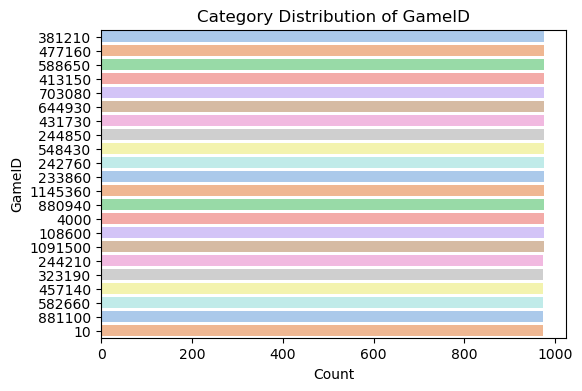


Value counts for Type:
Type
Sandbox                      2924
Horror                        976
Co-op                         976
Adventure                     976
Farming Sim                   975
Management                    975
Base Building                 975
Pixel Graphics                975
Dwarf                         975
Open World Survival Craft     975
Open World                    975
Action Roguelike              975
Funny                         975
Survival                      975
Cyberpunk                     975
Racing                        974
Colony Sim                    974
City Builder                  974
Physics                       974
Action                        974
Name: count, dtype: int64


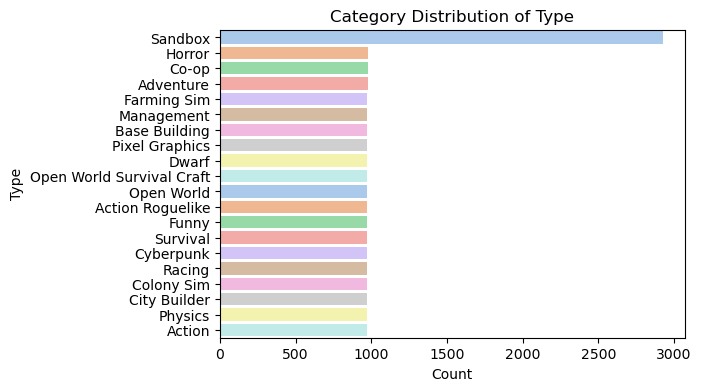


Value counts for Publisher:
Publisher
Valve                         1949
Curve Games                    976
Motion Twin                    976
Behaviour Interactive Inc.     976
ConcernedApe                   975
Endnight Games Ltd             975
Frontier Developments          975
Numantian Games                975
Igara Studio                   975
Keen Software House            975
Coffee Stain Publishing        975
Lo-Fi Games                    975
Supergiant Games               975
Rebuilt Games                  975
The Indie Stone                975
CD PROJEKT RED                 975
Klei Entertainment             974
11 bit studios                 974
Pearl Abyss                    974
Nolla Games                    974
Kunos Simulazioni              974
Name: count, dtype: int64


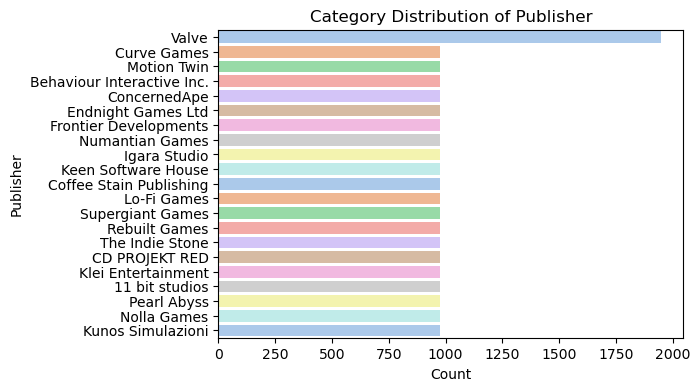

In [13]:
print("\n--- Categorical Summary ---")
for col in cat_cols[:]:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())

    plt.figure(figsize=(6, 4))
    sns.countplot(y=df[col], order=df[col].value_counts().index, palette="pastel")
    plt.title(f"Category Distribution of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.show()

In [14]:
cleaned_df = df.copy()

## 進階欄位生成

### 折扣率

In [15]:
# 折扣率 = （原價 - 當下價格）/ 原價，因此為折扣率為正表示降價
cleaned_df['DiscountRate'] = (cleaned_df['OriginPrice'] - cleaned_df['Final price']) / cleaned_df['OriginPrice']

### 遊戲年齡

In [16]:
# 遊戲年齡（年） = 當下日期 - 推出日期
cleaned_df['Age'] = (cleaned_df['Date'] - cleaned_df['ReleaseDate']).dt.days / 365

### 累積評價正面率

In [17]:
cleaned_df['AccumulatedPositiveRate'] = cleaned_df['Positive reviews'] / (cleaned_df['Positive reviews'] - cleaned_df['Negative reviews'])

# cleaned_df['Positive reviews on that day'] = cleaned_df['Positive reviews'] - cleaned_df['Positive reviews'].shift(1)
# cleaned_df['Negative reviews on that day'] = cleaned_df['Negative reviews'] - cleaned_df['Negative reviews'].shift(1)

### 是否為平台促銷期

In [18]:
# 建立促銷期間表
steam_sales = pd.DataFrame({
    'sale_name': [
        'Summer Sale 2023', 'Halloween Sale 2023', 'Autumn Sale 2023', 'Winter Sale 2023',
        'Lunar New Year Sale 2024', 'Spring Sale 2024', 'Summer Sale 2024', 'Autumn Sale 2024', 'Winter Sale 2024',
        'Lunar New Year Sale 2025', 'Spring Sale 2025'
    ],
    'start_date': pd.to_datetime([
        '2023-06-29', '2023-10-26', '2023-11-21', '2023-12-21',
        '2024-02-06', '2024-03-14', '2024-06-27', '2024-11-27', '2024-12-19',
        '2025-01-26', '2025-03-13'
    ]),
    'end_date': pd.to_datetime([
        '2023-07-13', '2023-11-02', '2023-11-28', '2024-01-04',
        '2024-02-15', '2024-03-21', '2024-07-11', '2024-12-04', '2025-01-02',
        '2025-02-09', '2025-03-20'
    ])
})

# 新增欄位，預設為 0
cleaned_df['SalePeriod'] = 0

# 逐一比對促銷期間
for _, row in steam_sales.iterrows():
    mask = (cleaned_df['Date'] >= row['start_date']) & (cleaned_df['Date'] <= row['end_date'])
    cleaned_df.loc[mask, 'SalePeriod'] = 1

### 玩家數、追蹤人數、正面率的指定期間移動平均增長率

In [19]:
def process_all_games(df):
    def process_game(group):
        group = group.sort_values('Date')
        group.set_index('Date', inplace=True)
        
        # players 的移動平均
        group['AvgPlayers1W'] = group['Players'].rolling(window='7D').mean().shift(1)
        group['AvgPlayers2W'] = group['Players'].rolling(window='14D').mean().shift(1)
        group['AvgPlayers1M'] = group['Players'].rolling(window='30D').mean().shift(1)
        # players MA 增長率
        group['PlayerGrowthRate1W'] = group['AvgPlayers1W'].pct_change(periods=7)
        group['PlayerGrowthRate2W'] = group['AvgPlayers2W'].pct_change(periods=14)
        group['PlayerGrowthRate1M'] = group['AvgPlayers1M'].pct_change(periods=30)

        # followers 增長率
        group['FollowersGrowthRate1W'] = group['Followers'].pct_change(periods=7).shift(1)
        group['FollowersGrowthRate2W'] = group['Followers'].pct_change(periods=14).shift(1)
        group['FollowersGrowthRate1M'] = group['Followers'].pct_change(periods=30).shift(1)

        group['PositiveRateGrowthRate1W'] = group['AccumulatedPositiveRate'].pct_change(periods=7).shift(1)
        group['PositiveRateGrowthRate2W'] = group['AccumulatedPositiveRate'].pct_change(periods=14).shift(1)
        group['PositiveRateGrowthRate1M'] = group['AccumulatedPositiveRate'].pct_change(periods=30).shift(1)

        # positive reviews 
        # group['PositiveReview1W'] = group['Positive reviews on that day'].rolling(window='7D').sum()
        # group['NegativeReview1W'] = group['Negative reviews on that day'].rolling(window='7D').sum()
        # group['PositiveReview2W'] = group['Positive reviews on that day'].rolling(window='14D').sum()
        # group['NegativeReview2W'] = group['Negative reviews on that day'].rolling(window='14D').sum()
        # group['PositiveReview1M'] = group['Positive reviews on that day'].rolling(window='30D').sum()
        # group['NegativeReview1M'] = group['Negative reviews on that day'].rolling(window='30D').sum()
        # positive reviews 的移動平均
        # group['PositiveRate1W'] = np.where(
            # group['PositiveReview1W'] - group['NegativeReview1W'] == 0,
            # 0, 
            # group['PositiveReview1W'] / (group['PositiveReview1W'] - group['NegativeReview1W'])
        # )       
        # group['PositiveRate2W'] = np.where(
            # group['PositiveReview2W'] - group['NegativeReview2W'] == 0,
            # 0, 
            # group['PositiveReview2W'] / (group['PositiveReview2W'] - group['NegativeReview2W'])
        # )
        # group['PositiveRate1M'] = np.where(
            # group['PositiveReview1M'] - group['NegativeReview1M'] == 0,
            # 0, 
            # group['PositiveReview1M'] / (group['PositiveReview1M'] - group['NegativeReview1M'])
        # )
        # positive reviews MA 增長率
        # group['PositiveRateGrowthRate1W'] = group['PositiveRate1W'].pct_change(periods=7)
        # group['PositiveRateGrowthRate2W'] = group['PositiveRate2W'].pct_change(periods=14)
        # group['PositiveRateGrowthRate1M'] = group['PositiveRate1M'].pct_change(periods=30)

        return group

    result = cleaned_df.groupby('GameID', group_keys=False).apply(process_game).reset_index()
    return result

In [20]:
gen_cols_df = process_all_games(cleaned_df)

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_33337/1970219080.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = cleaned_df.groupby('GameID', group_keys=False).apply(process_game).reset_index()


### 欄位生成結果統整

In [21]:
# 確認欄位生成狀況
gen_cols_df.head()

,Date,Players,Final price,Followers,Positive reviews,Negative reviews,DiscountDuration,GameID,ReleaseDate,OriginPrice,Type,MultiPlayer,Publisher,ConstantDiscount,Has_DLC,Has_Sequel,DiscountRate,Age,AccumulatedPositiveRate,SalePeriod,AvgPlayers1W,AvgPlayers2W,AvgPlayers1M,PlayerGrowthRate1W,PlayerGrowthRate2W,PlayerGrowthRate1M,FollowersGrowthRate1W,FollowersGrowthRate2W,FollowersGrowthRate1M,PositiveRateGrowthRate1W,PositiveRateGrowthRate2W,PositiveRateGrowthRate1M
0,2023-01-01,14817.0,186.0,194409.0,207951.0,-5310.0,0,10,2000-11-01,186.0,Action,1,Valve,0,0,0,0.0,22.180822,0.975101,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,16200.0,186.0,194452.0,207951.0,-5310.0,0,10,2000-11-01,186.0,Action,1,Valve,0,0,0,0.0,22.183562,0.975101,0,14817.000000,14817.000000,14817.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,16339.0,186.0,194501.0,208150.0,-5312.0,0,10,2000-11-01,186.0,Action,1,Valve,0,0,0,0.0,22.186301,0.975115,0,15508.500000,15508.500000,15508.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-04,16518.0,186.0,194549.0,208247.0,-5315.0,0,10,2000-11-01,186.0,Action,1,Valve,0,0,0,0.0,22.189041,0.975113,0,15785.333333,15785.333333,15785.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-05,16656.0,186.0,194602.0,208327.0,-5316.0,0,10,2000-11-01,186.0,Action,1,Valve,0,0,0,0.0,22.191781,0.975117,0,15968.500000,15968.500000,15968.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# 確認總欄位數
gen_cols_df.columns

Index(['Date', 'Players', 'Final price', 'Followers', 'Positive reviews', 'Negative reviews', 'DiscountDuration', 'GameID', 'ReleaseDate', 'OriginPrice', 'Type', 'MultiPlayer', 'Publisher', 'ConstantDiscount', 'Has_DLC', 'Has_Sequel', 'DiscountRate', 'Age', 'AccumulatedPositiveRate', 'SalePeriod', 'AvgPlayers1W', 'AvgPlayers2W', 'AvgPlayers1M', 'PlayerGrowthRate1W', 'PlayerGrowthRate2W', 'PlayerGrowthRate1M', 'FollowersGrowthRate1W', 'FollowersGrowthRate2W', 'FollowersGrowthRate1M', 'PositiveRateGrowthRate1W', 'PositiveRateGrowthRate2W', 'PositiveRateGrowthRate1M'], dtype='object')

In [23]:
# 確認數值欄位分布
gen_cols_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,21447,2024-05-01 17:37:37.490557952,2023-01-01 00:00:00,2023-09-01 00:00:00,2024-05-02 00:00:00,2024-12-31 00:00:00,2025-08-31 00:00:00,NaN
Players,21447.0,17114.884786,1518.0,4230.0,8066.0,21757.5,274526.0,22067.763651
Final price,21447.0,388.032918,0.0,238.0,318.0,408.0,1599.0,289.443828
Followers,21447.0,556457.903576,30234.0,238101.0,346091.0,711684.0,2744924.0,559179.44974
Positive reviews,21447.0,252774.312025,12286.0,70556.0,132707.0,320531.5,1138939.0,261927.01439
Negative reviews,21447.0,-21816.461836,-174531.0,-16337.5,-7856.0,-4637.5,-86.0,37991.807862
DiscountDuration,21447.0,3.552432,0.0,0.0,0.0,0.0,86.0,8.375242
ReleaseDate,21447,2016-12-14 15:14:24.624422912,2000-11-01 00:00:00,2016-02-26 00:00:00,2018-08-06 00:00:00,2019-07-30 00:00:00,2020-12-10 00:00:00,NaN
OriginPrice,21447.0,454.862545,186.0,318.0,379.0,438.0,1599.0,300.377865
MultiPlayer,21447.0,0.545484,0.0,0.0,1.0,1.0,1.0,0.497938


## 將列改為折扣事件導向

### 標記折扣首日

In [24]:
# 依 GameID 與日期排序
gen_cols_df = gen_cols_df.sort_values(['GameID', 'Date']).reset_index(drop=True)

# 假設 gen_cols_df 已經存在，並且日期是索引，已經排序好

# 1. 計算 DLC / Sequel 的累積總和
gen_cols_df['cumulative_DLC'] = gen_cols_df.groupby('GameID')['Has_DLC'].cumsum()
gen_cols_df['cumulative_Sequel'] = gen_cols_df.groupby('GameID')['Has_Sequel'].cumsum()

# 2. 【新增步驟】計算昨天的累積總和 (使用 .shift(1))
# 這樣在促銷當天計算時，就不會包含當天的內容更新
gen_cols_df['PrevDay_cumulative_DLC'] = gen_cols_df.groupby('GameID')['cumulative_DLC'].shift(1)
gen_cols_df['PrevDay_cumulative_Sequel'] = gen_cols_df.groupby('GameID')['cumulative_Sequel'].shift(1)


# 3. 修改後的函數：找出每款遊戲上一次折扣時的累積值
def calc_since_last_discount(group):
    # last_dlc 和 last_seq 存放「上一次促銷結束時」的累積值
    last_dlc = 0
    last_seq = 0
    dlc_since = []
    seq_since = []
    
    for _, row in group.iterrows():
        if row['DiscountRate'] != 0:  # 有折扣的日子
            # --- 關鍵修改 ---
            # 使用昨天的累積值 (PrevDay_...) 來計算自上次促銷以來的增量
            # 如果是遊戲第一天就有折扣，PrevDay_... 會是 NaN，需要用 0 替代
            prev_day_dlc = row['PrevDay_cumulative_DLC'] if pd.notna(row['PrevDay_cumulative_DLC']) else 0
            prev_day_seq = row['PrevDay_cumulative_Sequel'] if pd.notna(row['PrevDay_cumulative_Sequel']) else 0
            
            dlc_since.append(prev_day_dlc - last_dlc)
            seq_since.append(prev_day_seq - last_seq)
            # ----------------
            
            # 更新基準點：使用當天結束時的累積值，作為下一次促銷的起點
            last_dlc = row['cumulative_DLC']
            last_seq = row['cumulative_Sequel']
        else:
            dlc_since.append(None)
            seq_since.append(None)
    
    group['DLC_since_last_discount'] = dlc_since
    group['Sequel_since_last_discount'] = seq_since
    return group

# 4. 套用函數到每款遊戲
gen_cols_df = gen_cols_df.groupby('GameID', group_keys=False).apply(calc_since_last_discount)

# 5. 清理臨時欄位
gen_cols_df = gen_cols_df.drop(columns=['PrevDay_cumulative_DLC', 'PrevDay_cumulative_Sequel'])
# ---------------------------------------------------------
# ✅ 新增：找出「每次折扣的第一天」
# ---------------------------------------------------------
# 建立欄位代表有無折扣
gen_cols_df['DiscountOrNot'] = (gen_cols_df['DiscountRate'] != 0).astype(int)

# 以遊戲為單位找出折扣開始日（當天有折扣，且前一天沒有）
gen_cols_df['IsDiscountStart'] = gen_cols_df.groupby('GameID')['DiscountOrNot'].transform(
    lambda x: (x == 1) & (x.shift(1, fill_value=0) == 0)
)

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_33337/4292929959.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gen_cols_df = gen_cols_df.groupby('GameID', group_keys=False).apply(calc_since_last_discount)


### 過去一季內折扣頻率

In [25]:
gen_cols_df = gen_cols_df.sort_values(['GameID', 'Date']).reset_index(drop=True)

def calc_discount_freq(g):
    # 確保日期唯一，必要時加上行號以建立唯一索引
    g = g.copy()
    g = g.reset_index(drop=True)
    g = g.set_index(pd.to_datetime(g['Date']))
    
    # 計算過去 90 天折扣出現次數
    freq = g['IsDiscountStart'].rolling('90D', min_periods=1).sum()
    g['DiscountFreq3M'] = freq.values
    return g.reset_index(drop=True)

gen_cols_df = gen_cols_df.groupby('GameID', group_keys=False).apply(calc_discount_freq)

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_33337/2066447036.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gen_cols_df = gen_cols_df.groupby('GameID', group_keys=False).apply(calc_discount_freq)


### 僅留下折扣首日

In [26]:
df_result = gen_cols_df[gen_cols_df['IsDiscountStart']].reset_index(drop=True)


## 結果檔案整理

### 刪除不需欄

In [27]:
df_result.drop(columns=['Players', 'Followers', 'Positive reviews', 'Negative reviews', 'ReleaseDate', 'AvgPlayers1W', 'AvgPlayers2W', 'AvgPlayers1M', 'Has_DLC', 'Has_Sequel', 'cumulative_DLC', 'cumulative_Sequel', 'DiscountOrNot', 'IsDiscountStart'], inplace=True)

### 欄位順序調整

In [28]:
sorted_cols = ['Date', 'GameID', 'Type', 'MultiPlayer', 'Publisher', 'ConstantDiscount','Final price', 'OriginPrice', 'DiscountRate', 'DiscountDuration', 'DiscountFreq3M', 'Age', 'AccumulatedPositiveRate', 'SalePeriod', 'PlayerGrowthRate1W', 'PlayerGrowthRate2W', 'PlayerGrowthRate1M', 'FollowersGrowthRate1W', 'FollowersGrowthRate2W', 'FollowersGrowthRate1M', 'PositiveRateGrowthRate1W', 'PositiveRateGrowthRate2W', 'PositiveRateGrowthRate1M', 'DLC_since_last_discount', 'Sequel_since_last_discount']
df_result = df_result.reindex(columns=sorted_cols)

### 篩選所需時間範圍

In [29]:
start_date = '2023-05-01'
end_date = '2025-08-31'

df_result = df_result[(df_result['Date'] >= start_date) & (df_result['Date'] <= end_date)]

### 欄位型態調整

In [30]:
df_result['DLC_since_last_discount'] = df_result['DLC_since_last_discount'].astype(int)
df_result['Sequel_since_last_discount'] = df_result['Sequel_since_last_discount'].astype(int)
df_result['DiscountFreq3M'] = df_result['DiscountFreq3M'].astype(int)

### 結果檔案觀察

In [31]:
df_result.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,409,2024-07-02 00:45:46.210268672,2023-05-01 00:00:00,2023-12-11 00:00:00,2024-06-27 00:00:00,2025-01-09 00:00:00,2025-08-31 00:00:00,NaN
MultiPlayer,409.0,0.503667,0.0,0.0,1.0,1.0,1.0,0.500599
ConstantDiscount,409.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Final price,409.0,220.880196,0.0,119.0,160.0,278.0,959.0,177.979242
OriginPrice,409.0,501.114914,186.0,318.0,398.0,488.0,1599.0,326.580574
DiscountRate,409.0,0.572639,0.034301,0.5,0.600457,0.701005,1.0,0.193898
DiscountDuration,409.0,11.222494,1.0,7.0,11.0,14.0,32.0,5.299545
DiscountFreq3M,409.0,2.701711,1.0,2.0,3.0,3.0,6.0,0.898813
Age,409.0,7.025569,2.50137,4.723288,6.027397,7.961644,24.665753,3.988664
AccumulatedPositiveRate,409.0,0.917436,0.738856,0.885042,0.946994,0.967883,0.992643,0.065307


In [32]:
df_result.head()

,Date,GameID,Type,MultiPlayer,Publisher,ConstantDiscount,Final price,OriginPrice,DiscountRate,DiscountDuration,DiscountFreq3M,Age,AccumulatedPositiveRate,SalePeriod,PlayerGrowthRate1W,PlayerGrowthRate2W,PlayerGrowthRate1M,FollowersGrowthRate1W,FollowersGrowthRate2W,FollowersGrowthRate1M,PositiveRateGrowthRate1W,PositiveRateGrowthRate2W,PositiveRateGrowthRate1M,DLC_since_last_discount,Sequel_since_last_discount
1,2023-06-29,10,Action,1,Valve,0,18.0,186.0,0.903226,14,1,22.671233,0.975168,1,-0.017793,-0.032626,-0.039192,0.000643,0.001311,0.003055,0.000042,0.000018,0.000018,0,0
2,2023-09-12,10,Action,1,Valve,0,18.0,186.0,0.903226,7,2,22.876712,0.974990,0,-0.010609,0.031983,0.006604,0.000513,0.001057,0.002307,0.000016,0.000035,-0.000034,0,0
3,2023-11-21,10,Action,1,Valve,0,18.0,186.0,0.903226,7,2,23.068493,0.974686,1,-0.053161,-0.030716,0.027451,0.001346,0.001994,0.004094,-0.000154,-0.000151,-0.000155,0,0
4,2023-12-21,10,Action,1,Valve,0,19.0,186.0,0.897849,14,2,23.150685,0.974675,1,-0.032239,-0.032172,-0.014952,0.000824,0.001743,0.004816,0.000014,0.000014,-0.000016,0,0
5,2024-03-14,10,Action,1,Valve,0,18.0,186.0,0.903226,7,2,23.380822,0.974604,1,0.005641,0.045146,0.009495,0.001006,0.001877,0.003727,0.000014,-0.000004,0.000008,0,0


In [33]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 409 entries, 1 to 454
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        409 non-null    datetime64[ns]
 1   GameID                      409 non-null    object        
 2   Type                        409 non-null    object        
 3   MultiPlayer                 409 non-null    int64         
 4   Publisher                   409 non-null    object        
 5   ConstantDiscount            409 non-null    int64         
 6   Final price                 409 non-null    float64       
 7   OriginPrice                 409 non-null    float64       
 8   DiscountRate                409 non-null    float64       
 9   DiscountDuration            409 non-null    int64         
 10  DiscountFreq3M              409 non-null    int64         
 11  Age                         409 non-null    float64       
 12 

## 輸出結果檔案

In [34]:
df_result.to_csv('/Users/peijiefang/Downloads/data analysis project/extent-of-discount-rate-DE.csv', index=False, encoding='utf-8-sig')